In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from astropy.coordinates import SkyCoord
from astropy import units as u
from joblib import load

In [2]:
df_all_model = pd.read_parquet('../scripts/nway_csc21_gaia3_full_neg_study_dis_niter200.parquet')

In [3]:
benchmark_ids = load('../scripts/jobs/models/neg_study_dis_niter200_withint_with_int_5X_lgbm_0-3_20241113_235113/benchmark_ids.joblib')

In [4]:
df_test = df_all_model[df_all_model['csc21_name'].isin(benchmark_ids)]

In [5]:
def get_match_label_simple(df, p_threshold=0.32):
    """get match labels for sources meeting position and probability criteria"""

    df_in_crit = df.copy()
    
    # position criteria mask
    pos_mask = (
        ((df_in_crit['min_theta_mean'] < 3) & (df_in_crit['separation'] <= 1.3)) |
        ((df_in_crit['min_theta_mean'].between(3, 6)) & (df_in_crit['separation'] <= 1.3)) |
        ((df_in_crit['min_theta_mean'] > 6) & (df_in_crit['separation'] <= 2.2))
    )
    
    # combined criteria mask
    mask = pos_mask #& (df_in_crit['p_any'] > 0.5)
    
    # set labels 
    df_in_crit.loc[:, 'label'] = 0
    df_in_crit.loc[mask & (df_in_crit['p_match_ind'] > p_threshold), 'label'] = 1
    
    return df_in_crit[mask]

In [6]:
df_in_crit = get_match_label_simple(df_test)

In [7]:
df_test.csc21_name.unique().shape

(6056,)

In [8]:
df_in_crit.csc21_name.unique().shape

(6056,)

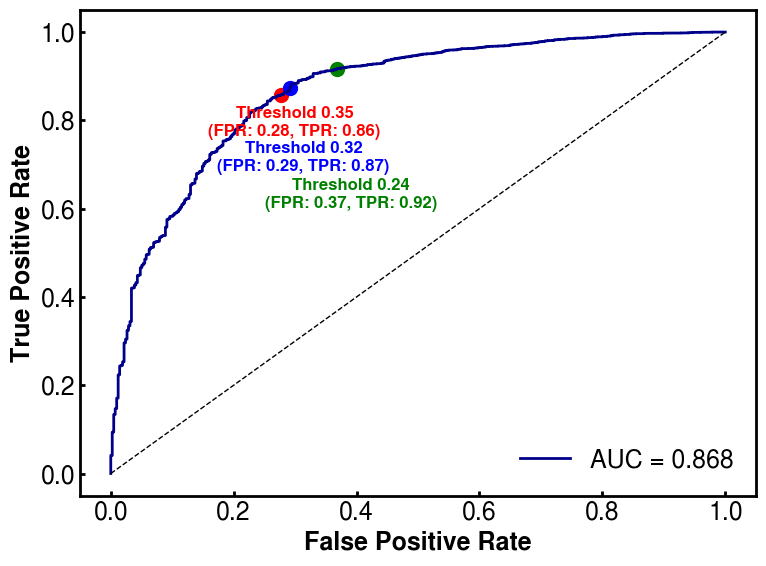

In [9]:
from sklearn.metrics import roc_curve, auc

# plotting params
plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

# calculate ROC
fpr, tpr, trs = roc_curve(df_in_crit['match_flag'] == 1, df_in_crit['p_match_ind'])
roc_auc = auc(fpr, tpr)

# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkblue', lw=2, 
        label=f'AUC = {roc_auc:.3f}')

# style
ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_xlabel('False Positive Rate', weight='bold')
ax.set_ylabel('True Positive Rate', weight='bold')
ax.tick_params(direction='in', which='both')
ax.legend(frameon=False, loc='lower right')

# Find the closest points to 0.35 and 0.24
closest_035 = np.argmin(np.abs(trs - 0.35))
closest_024 = np.argmin(np.abs(trs - 0.24))
closest_032 = np.argmin(np.abs(trs - 0.32))
#Annotate the closest points
ax.scatter(fpr[closest_035], tpr[closest_035], color='red', s=100, label=f'Threshold 0.35 (FPR: {fpr[closest_035]:.2f}, TPR: {tpr[closest_035]:.2f})')
ax.scatter(fpr[closest_024], tpr[closest_024], color='green', s=100, label=f'Threshold 0.24 (FPR: {fpr[closest_024]:.2f}, TPR: {tpr[closest_024]:.2f})')

# Find the closest point to 0.32
closest_032 = np.argmin(np.abs(trs - 0.32))
ax.scatter(fpr[closest_032], tpr[closest_032], color='blue', s=100, label=f'Threshold 0.32 (FPR: {fpr[closest_032]:.2f}, TPR: {tpr[closest_032]:.2f})')

# Annotate the points
ax.annotate(f'Threshold 0.35\n(FPR: {fpr[closest_035]:.2f}, TPR: {tpr[closest_035]:.2f})', 
                                                (fpr[closest_035], tpr[closest_035]), 
                                                textcoords="offset points", 
                                                xytext=(10,-30), 
                                                ha='center', color='red', fontsize=12, weight='bold')

ax.annotate(f'Threshold 0.24\n(FPR: {fpr[closest_024]:.2f}, TPR: {tpr[closest_024]:.2f})', 
                                                (fpr[closest_024], tpr[closest_024]), 
                                                textcoords="offset points", 
                                                xytext=(10,-100), 
                                                ha='center', color='green', fontsize=12, weight='bold')

ax.annotate(f'Threshold 0.32\n(FPR: {fpr[closest_032]:.2f}, TPR: {tpr[closest_032]:.2f})', 
                                                (fpr[closest_032], tpr[closest_032]), 
                                                textcoords="offset points", 
                                                xytext=(10,-60), 
                                                ha='center', color='blue', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

0.2806023732576762


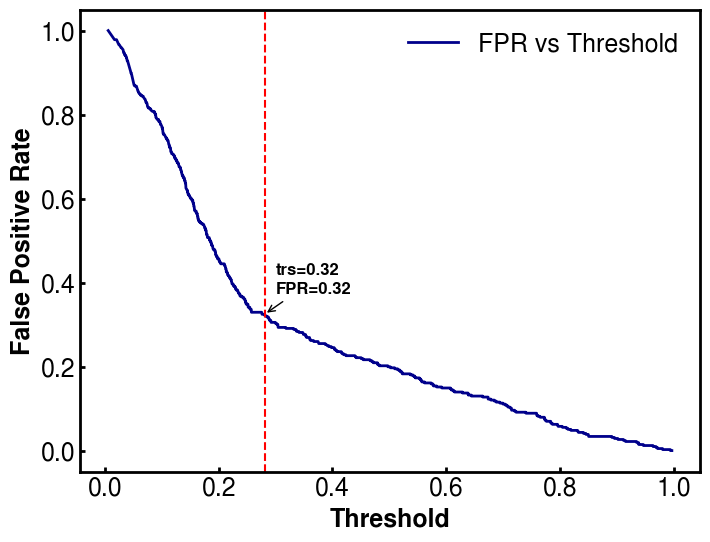

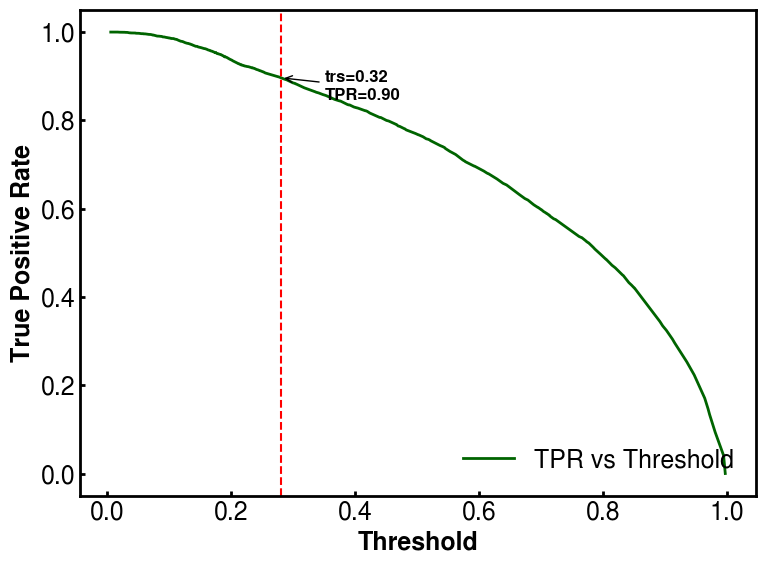

In [15]:
# Plotting params
plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

# Plot fpr vs trs
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(trs, fpr, color='darkblue', lw=2, label='FPR vs Threshold')
ax.set_xlabel('Threshold', weight='bold')
ax.set_ylabel('False Positive Rate', weight='bold')
ax.tick_params(direction='in', which='both')
ax.legend(frameon=False, loc='upper right')

# Highlight trs=0.32
trs_032_index = np.argmin(np.abs(trs - 0.28))
ax.axvline(x=trs[trs_032_index], color='red', linestyle='--')
ax.annotate(f'trs=0.32\nFPR={fpr[trs_032_index]:.2f}', 
            xy=(trs[trs_032_index], fpr[trs_032_index]), 
            xytext=(trs[trs_032_index] + 0.02, fpr[trs_032_index] + 0.05),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=12, color='black', weight='bold')

print(trs[trs_032_index])

# Plot tpr vs trs
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(trs, tpr, color='darkgreen', lw=2, label='TPR vs Threshold')
ax.set_xlabel('Threshold', weight='bold')
ax.set_ylabel('True Positive Rate', weight='bold')
ax.tick_params(direction='in', which='both')
ax.legend(frameon=False, loc='lower right')

# Highlight trs=0.32
ax.axvline(x=trs[trs_032_index], color='red', linestyle='--')
ax.annotate(f'trs=0.32\nTPR={tpr[trs_032_index]:.2f}', 
            xy=(trs[trs_032_index], tpr[trs_032_index]), 
            xytext=(trs[trs_032_index] + 0.07, tpr[trs_032_index] - 0.05),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=12, color='black', weight='bold')

plt.tight_layout()
plt.show()
